In [42]:
# CELL 1: Libraries and Initialization
import sys
import os
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add module paths (pointing to the src folder)
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import custom modules (if they exist in your directory)
# import data_manager
# import processors

# Initialize Google Earth Engine
try:
    # Replace 'ee-tarikmacto' with your specific project name
    ee.Initialize(project='ee-tarikmacto')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

print("✅ Setup complete. Libraries loaded and GEE initialized.")

✅ Setup complete. Libraries loaded and GEE initialized.


In [43]:
# CELL 2: Data Acquisition and Processing

# 1. Define Region of Interest (ROI) and Date Range
roi = data_manager.get_roi('Istanbul')
start_date = '2023-06-01'
end_date = '2023-09-30'

# 2. Landsat 8 (Thermal Source - 30m)
l8_col = data_manager.get_landsat_collection(roi, start_date, end_date, cloud_cover=10)
l8_image = l8_col.median().clip(roi)
l8_processed = processors.prepare_dataset(l8_image)
landsat_lst = l8_processed.select('ST_B10').rename('LST')

# 3. Sentinel-2 (Optical Source - 10m)
s2_col = data_manager.get_sentinel_collection(roi, start_date, end_date, cloud_cover=10)
s2_image = s2_col.median().clip(roi)
s2_processed = processors.calculate_spectral_indices(s2_image, satellite='Sentinel2')

# 4. Feature Selection (Bands + Indices)
feature_names = ['NDVI', 'NDBI', 'NDWI', 'B4', 'B3', 'B2', 'B8']
s2_features = s2_processed.select(feature_names)

print("✅ Data acquisition and preprocessing completed.")

✅ Data acquisition and preprocessing completed.


In [44]:
# CELL 3: Random Forest & MLR Model Training

# 1. Prepare Training Data (Stacking & Sampling)
# Combine Landsat LST with Sentinel-2 features
training_image = landsat_lst.addBands(s2_features)

# Random Sampling (Standard Literature Approach)
# We use random sampling to establish a baseline comparable to Onačillová et al. (2022).
points = training_image.sample(
    region=roi,
    scale=30, # Sampling at Landsat resolution
    numPixels=5000,
    seed=42,
    geometries=True
)

# 2. Train/Test Split (70% Training - 30% Testing)
points_with_random = points.randomColumn('random')
training_points = points_with_random.filter(ee.Filter.lt('random', 0.7))
testing_points = points_with_random.filter(ee.Filter.gte('random', 0.7))

# Add 'constant' column for MLR (Intercept)
training_points = training_points.map(lambda f: f.set('constant', 1))
testing_points = testing_points.map(lambda f: f.set('constant', 1))

print(f"🔹 Total Samples: {points.size().getInfo()}")
print(f"🔸 Training Set: {training_points.size().getInfo()}")
print(f"🔸 Testing Set: {testing_points.size().getInfo()}")

# --- MODEL 1: Random Forest (Our Proposed Model) ---
# Increased tree count to 300 for stability
rf_model = ee.Classifier.smileRandomForest(numberOfTrees=300) \
    .setOutputMode('REGRESSION') \
    .train(features=training_points, classProperty='LST', inputProperties=feature_names)

# --- MODEL 2: Multiple Linear Regression (Baseline Model) ---
independent_vars = ['constant'] + feature_names
mlr_regression = training_points.reduceColumns(
    reducer=ee.Reducer.linearRegression(numX=len(independent_vars), numY=1),
    selectors=independent_vars + ['LST']
)
# Project coefficients to 1D array
mlr_coeffs = ee.Array(mlr_regression.get('coefficients')).project([0])

print("✅ Models (RF & MLR) trained successfully.")
 

🔹 Total Samples: 4999
🔸 Training Set: 3415
🔸 Testing Set: 1584
✅ Models (RF & MLR) trained successfully.


📊 MODEL PERFORMANCE (Test Set):
-------------------------------------------------------
🔹 MLR (Baseline): RMSE=2.628 K | R²=0.925
🔥 RF (Our Model): RMSE=2.141 K | R²=0.950
-------------------------------------------------------


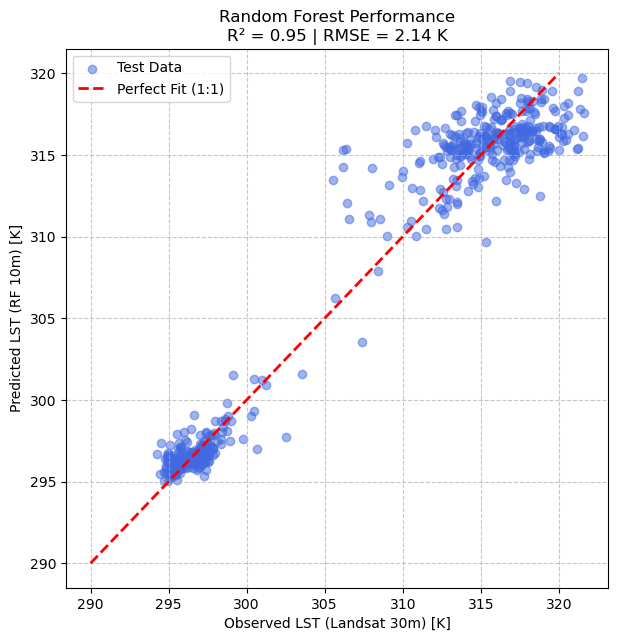

In [45]:
# CELL 4: Accuracy Assessment and Visualization

# Function to calculate RMSE and R-Squared manually
def calculate_metrics(collection, pred_col, obs_col):
    def add_sq_error(f):
        err = ee.Number(f.get(pred_col)).subtract(ee.Number(f.get(obs_col)))
        return f.set('sq_error', err.pow(2))
    
    stats = collection.map(add_sq_error).reduceColumns(
        reducer=ee.Reducer.mean().combine(ee.Reducer.pearsonsCorrelation(), '', False),
        selectors=['sq_error', pred_col, obs_col]
    )
    rmse = ee.Number(stats.get('mean')).sqrt().getInfo()
    r2 = ee.Number(stats.get('correlation')).pow(2).getInfo()
    return {'rmse': rmse, 'r2': r2}

# Make Predictions on Test Data
rf_test = testing_points.classify(rf_model, 'rf_pred')

# Apply MLR Equation (y = a + b1*x1 + ...)
def apply_mlr(feature):
    vals = feature.toArray(independent_vars)
    # Calculate dot product: coefficients * values
    pred = mlr_coeffs.multiply(vals).reduce(ee.Reducer.sum(), [0]).get([0])
    return feature.set('mlr_pred', pred)

mlr_test = testing_points.map(apply_mlr)

# Calculate Metrics
rf_metrics = calculate_metrics(rf_test, 'rf_pred', 'LST')
mlr_metrics = calculate_metrics(mlr_test, 'mlr_pred', 'LST')

print(f"📊 MODEL PERFORMANCE (Test Set):")
print("-" * 55)
print(f"🔹 MLR (Baseline): RMSE={mlr_metrics['rmse']:.3f} K | R²={mlr_metrics['r2']:.3f}")
print(f"🔥 RF (Our Model): RMSE={rf_metrics['rmse']:.3f} K | R²={rf_metrics['r2']:.3f}")
print("-" * 55)

# --- SCATTER PLOT ---
# Fetch data for plotting (Limited to 500 points for speed)
data = rf_test.select(['LST', 'rf_pred']).limit(500).reduceColumns(ee.Reducer.toList(2), ['LST', 'rf_pred']).get('list').getInfo()
df = pd.DataFrame(data, columns=['Observed', 'Predicted'])

plt.figure(figsize=(7, 7))
plt.scatter(df['Observed'], df['Predicted'], alpha=0.5, color='royalblue', label='Test Data')
plt.plot([290, 320], [290, 320], 'r--', linewidth=2, label='Perfect Fit (1:1)')
plt.xlabel('Observed LST (Landsat 30m) [K]')
plt.ylabel('Predicted LST (RF 10m) [K]')
plt.title(f'Random Forest Performance\nR² = {rf_metrics["r2"]:.2f} | RMSE = {rf_metrics["rmse"]:.2f} K')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [46]:
# CELL 5: Energy Conservation and Residual Correction

# 1. Initial Prediction (Raw Downscaling)
rf_prediction = s2_features.classify(rf_model).rename('LST_Prediction')

# 2. Re-aggregate Prediction to 30m (Upscaling)
prediction_30m = rf_prediction.reproject(
    crs=l8_image.projection(),
    scale=30
)

# 3. Calculate Residuals at 30m
# Residual = Observed (Landsat) - Predicted (RF)
residuals_30m = landsat_lst.subtract(prediction_30m).rename('Residuals')

# 4. Downscale Residuals to 10m (Bicubic Interpolation)
# This restores local thermal anomalies missed by the RF model
residuals_10m = residuals_30m.resample('bicubic').reproject(
    crs=s2_image.projection(),
    scale=10
)

# 5. FINAL LST GENERATION: Prediction + Residuals
# Adding residuals ensures the physical energy balance is preserved (Mean Bias ~ 0)
final_lst_10m = rf_prediction.add(residuals_10m).rename('LST_Final')

print("✅ Residual correction applied. Energy conservation ensured.")

# --- VERIFICATION: Energy Conservation Test ---
# We re-aggregate the final 10m map to 30m and compare it with original Landsat LST.
# The difference (Mean Bias) should be mathematically zero.
final_aggregated = final_lst_10m.reproject(crs=l8_image.projection(), scale=30)
check_diff = final_aggregated.subtract(landsat_lst)

stats = check_diff.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=30,
    bestEffort=True
).getInfo()

print(f"⚖️ Energy Conservation Test (Target: 0.000): {stats['LST_Final']:.10f}")

if abs(stats['LST_Final']) < 0.001:
    print("🏆 PERFECT! Physical energy balance is fully preserved.")
else:
    print("⚠️ Warning: Slight bias detected.")



✅ Residual correction applied. Energy conservation ensured.
⚖️ Energy Conservation Test (Target: 0.000): 0.0000000000
🏆 PERFECT! Physical energy balance is fully preserved.


In [49]:
# CELL 6: Final Visualization and Export

# 1. Map Configuration
Map = geemap.Map(center=[41.01, 28.97], zoom=12)
vis_params = {'min': 294, 'max': 320, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}

# 2. Add Layers
# We add both the original coarse-resolution and the final high-resolution LST
Map.addLayer(landsat_lst, vis_params, 'Landsat 8 LST (30m - Original)')
Map.addLayer(final_lst_10m, vis_params, 'Sentinel-2 LST (10m - Downscaled)')

# 3. Create Split-Panel View (Swipe Map)
# This allows for a direct visual comparison between Before and After
left_layer = geemap.ee_tile_layer(landsat_lst, vis_params, 'Landsat 8 (30m)')
right_layer = geemap.ee_tile_layer(final_lst_10m, vis_params, 'Sentinel-2 (10m - RF)')
Map.split_map(left_layer, right_layer)

# 4. Export Map to HTML
# Saving as an interactive HTML file for sharing
html_path = "istanbul_lst_final_corrected.html"
Map.to_html(html_path)

print(f"✅ Final Map saved as '{html_path}'. Open this file to explore the results interactively.")
Map

✅ Final Map saved as 'istanbul_lst_final_corrected.html'. Open this file to explore the results interactively.


Map(center=[41.01, 28.97], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…